# NHANES Diabetes Prediction Model Pipeline

### By John Semerdjian and Spencer Frank

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
plt.style.use('seaborn-white')

# Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC

# Helper functions
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from nhanes.utils import GridSearchCVWrapper
# from nhanes.merge_data import merge_data

%matplotlib inline

### Import training and test sets

In [2]:
df_train = pd.read_csv('./data/diabetes_data_train.csv')
df_test = pd.read_csv('./data/diabetes_data_test.csv')

### Check proportion of missing values

In [3]:
df_train.isnull().sum(axis=0)/df_train.shape[0]

ALQ120Q     0.159791
BMXBMI      0.021759
BMXHT       0.016999
BMXLEG      0.030598
BMXWAIST    0.029465
BMXWT       0.014506
BPQ020      0.010653
DMDEDUC2    0.000000
INDHHINC    0.091795
LBXTC       0.018812
MCQ250A     0.000000
PAQ180      0.000000
RIAGENDR    0.000000
RIDAGEYR    0.000000
RIDRETH1    0.000000
SMD030      0.465322
status      0.000000
dtype: float64

### Impute values based on categorical or numerical data type

In [4]:
imp_ALQ120Q = df_train.ALQ120Q.value_counts().index[0]
imp_BMXBMI = df_train.BMXBMI.mean()
imp_BMXHT = df_train.BMXHT.mean()
imp_BMXWAIST = df_train.BMXWAIST.mean()
imp_BMXHT = df_train.BMXWT.mean()
imp_BMXLEG = df_train.BMXLEG.mean()
imp_BPQ020 = df_train.BPQ020.value_counts().index[0]
imp_INDHHINC = df_train.INDHHINC.value_counts().index[0]
imp_LBXTC = df_train.LBXTC.mean()

df_train.loc[df_train.SMD030.isnull(), 'SMD030']     = 0
df_train.loc[df_train.SMD030 == 999, 'SMD030']       = 18
df_train.loc[df_train.ALQ120Q.isnull(), 'ALQ120Q']   = imp_ALQ120Q
df_train.loc[df_train.BMXBMI.isnull(), 'BMXBMI']     = imp_BMXBMI
df_train.loc[df_train.BMXHT.isnull(), 'BMXHT']       = imp_BMXHT
df_train.loc[df_train.BMXWAIST.isnull(), 'BMXWAIST'] = imp_BMXWAIST
df_train.loc[df_train.BMXWT.isnull(), 'BMXWT']       = imp_BMXHT
df_train.loc[df_train.BMXLEG.isnull(), 'BMXLEG']     = imp_BMXLEG
df_train.loc[df_train.BPQ020.isnull(), 'BPQ020']     = imp_BPQ020
df_train.loc[df_train.INDHHINC.isnull(), 'INDHHINC'] = imp_INDHHINC
df_train.loc[df_train.LBXTC.isnull(), 'LBXTC']       = imp_LBXTC

df_test.loc[df_test.SMD030.isnull(), 'SMD030']       = 0
df_test.loc[df_test.SMD030 == 999, 'SMD030']         = 18
df_test.loc[df_test.ALQ120Q.isnull(), 'ALQ120Q']     = imp_ALQ120Q
df_test.loc[df_test.BMXBMI.isnull(), 'BMXBMI']       = imp_BMXBMI
df_test.loc[df_test.BMXHT.isnull(), 'BMXHT']         = imp_BMXHT
df_test.loc[df_test.BMXWAIST.isnull(), 'BMXWAIST']   = imp_BMXWAIST
df_test.loc[df_test.BMXWT.isnull(), 'BMXWT']         = imp_BMXHT
df_test.loc[df_test.BMXLEG.isnull(), 'BMXLEG']       = imp_BMXLEG
df_test.loc[df_test.BPQ020.isnull(), 'BPQ020']       = imp_BPQ020
df_test.loc[df_test.INDHHINC.isnull(), 'INDHHINC']   = imp_INDHHINC
df_test.loc[df_test.LBXTC.isnull(), 'LBXTC']         = imp_LBXTC

### Change feature data types

In [5]:
nhanes_dtype = dict(
    ALQ120Q  = np.int,
    BMXBMI   = np.float64,
    BMXHT    = np.float64,
    BMXWAIST = np.float64,
    BMXWT    = np.float64,
    BPQ020   = np.int,
    DMDEDUC2 = np.int,
    INDHHINC = np.int,
    MCQ250A  = np.int,
    PAQ180   = np.int,
    RIAGENDR = np.int,
    RIDAGEYR = np.float64,
    RIDRETH1 = np.int,
    SMD030   = np.int,
    status   = np.int
)

for k, v in nhanes_dtype.items():
    df_train[k] = df_train[k].astype(v)
    df_test[k] = df_test[k].astype(v)

### Split features and labels from training and test sets

In [6]:
X_train, y_train = df_train.drop(['status'], axis=1), df_train.status
X_test,  y_test  = df_test.drop(['status'], axis=1), df_test.status

## Grid Search Hyperaramters for Each Model

Note: The best hyperparamters based on grid search have been pre-selected in the models below.

### SVM

In [7]:
scale = MinMaxScaler(feature_range=(-1, 1)).fit(X_train)
X_train_scale = scale.transform(X_train)
X_test_scale = scale.transform(X_test)

In [8]:
svc_best_params, svc_best_score = GridSearchCVWrapper(
    model=SVC(), 
    param_grid=dict(
        C=[100], 
        kernel=["rbf"]
    ),
    X=X_train_scale,
    y=y_train
)
svc_best_params['probability'] = True

Best Params: {'kernel': 'rbf', 'C': 100}
Best Score: 0.822


### RandomForest

In [9]:
rf_best_params, rf_best_score = GridSearchCVWrapper(
    model=RandomForestClassifier(),
    param_grid=dict(
        criterion=["entropy"],
        min_samples_leaf=[15],
        min_samples_split=[2],
        max_features=["sqrt"]
    ),
    X=X_train,
    y=y_train
)

Best Params: {'min_samples_split': 2, 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 15}
Best Score: 0.819


### LogisticRegression

In [10]:
lg_best_params, lg_best_score = GridSearchCVWrapper(
    model=LogisticRegression(),
    param_grid=dict(
        penalty=["l1"]
    ),
    X=X_train,
    y=y_train
)

Best Params: {'penalty': 'l1'}
Best Score: 0.815


### KNN

In [11]:
knn_best_params, knn_best_score = GridSearchCVWrapper(
    model=KNeighborsClassifier(),
    param_grid=dict(
        n_neighbors=[200]
    ),
    X=X_train,
    y=y_train
)

Best Params: {'n_neighbors': 200}
Best Score: 0.808


### GradientBoosting

In [12]:
gbc_best_params, gbc_best_score = GridSearchCVWrapper(
    model=GradientBoostingClassifier(),
    param_grid=dict(
        loss=["deviance"],
        learning_rate=[0.1],
        n_estimators=[100],
        max_depth=[3],
        min_samples_split=[2],
        min_samples_leaf=[1],
        max_features=["sqrt"]
    ),
    X=X_train,
    y=y_train
)

Best Params: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'min_samples_split': 2, 'loss': 'deviance', 'max_features': 'sqrt', 'min_samples_leaf': 1}
Best Score: 0.83


### Feature importance

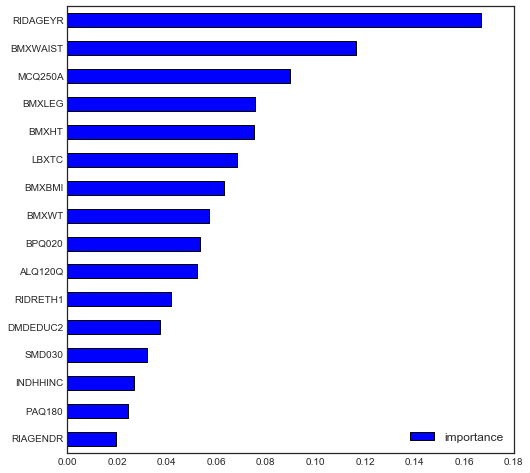

In [13]:
gbc = GradientBoostingClassifier(**gbc_best_params)
gbc_clf = gbc.fit(X_train, y_train)

pd.DataFrame({'importance': gbc_clf.feature_importances_}, index=X_train.columns) \
     .sort_values(by='importance') \
     .plot(kind='barh', figsize=(8,8));

### Assess Tradeoff between Recall and the Decision Threshold (T)

In [14]:
def precision_recall_thershold(pred_proba):
    t_recall_nodiab, t_recall_diab = [], []
    t_precision_nodiab, t_precision_diab = [], []
    for thresh in np.arange(0, 1, 0.01):
        precision, recall, fscore, support = metrics.precision_recall_fscore_support(
            y_test, 
            np.where(pred_proba[:,0] > thresh, 0, 1)
        )
        recall_nodiab, recall_diab = recall
        precision_nodiab, precision_diab = precision
        
        t_recall_nodiab.append(recall_nodiab)
        t_recall_diab.append(recall_diab)
        
        t_precision_nodiab.append(precision_nodiab)
        t_precision_diab.append(precision_diab)
        
    return t_precision_nodiab, t_precision_diab, \
            t_recall_nodiab, t_recall_diab   

In [15]:
gbc_proba = gbc_clf.predict_proba(X_test)

t_precision_nodiab, t_precision_diab, t_recall_nodiab, t_recall_diab = precision_recall_thershold(gbc_proba)

/Users/jsemer/.virtualenvs/NHANES/lib/python3.4/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


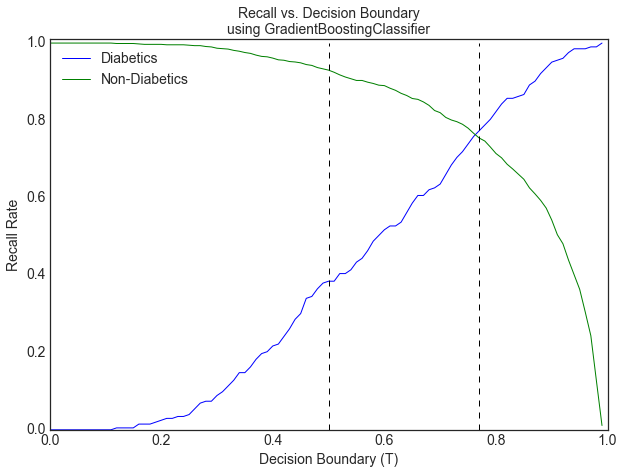

In [16]:
plt.figure(figsize=(10,7))
plt.plot(np.arange(0, 1, 0.01), t_recall_diab,   label='Diabetics')
plt.plot(np.arange(0, 1, 0.01), t_recall_nodiab, label='Non-Diabetics')
plt.plot([.5, .5], [0, 1], 'k--')
plt.plot([.77, .77], [0, 1], 'k--')
plt.ylim([0.0, 1.01])
plt.xlim([0.0, 1.0])
plt.legend(loc='upper left', fontsize=14)
plt.title('Recall vs. Decision Boundary\nusing GradientBoostingClassifier', fontsize=14)
plt.xlabel('Decision Boundary (T)', fontsize=14)
plt.ylabel('Recall Rate', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.savefig('./img/Recall_score.png')
plt.show()

### Performance Metrics 

In [17]:
threshold = .5

In [18]:
rf_clf = RandomForestClassifier(**rf_best_params).fit(X_train, y_train)
knn_clf = KNeighborsClassifier(**knn_best_params).fit(X_train, y_train)
lg_clf = LogisticRegression(**lg_best_params).fit(X_train, y_train)
svc_clf = SVC(**svc_best_params).fit(X_train_scale, y_train)

In [19]:
rf_proba = rf_clf.predict_proba(X_test)
knn_proba = knn_clf.predict_proba(X_test)
lg_proba = lg_clf.predict_proba(X_test)
svc_proba = svc_clf.predict_proba(X_test_scale)

In [20]:
# Create Ensemble
df_preds = pd.DataFrame({
        'LogisticRegression': lg_proba[:,1],
        'KNeighborsClassifier': knn_proba[:,1],
        'RandomForestClassifier': rf_proba[:,1],
        'GradientBoostingClassifier': gbc_proba[:,1],
        'SVC': svc_proba[:,1]
    })

df_preds.loc[:,'Ensemble'] = df_preds.mean(axis=1)

In [21]:
print('LogisticRegression')
print(metrics.classification_report(y_test, np.where(lg_proba[:,0] > threshold, 0, 1)))

print('KNeighborsClassifier')
print(metrics.classification_report(y_test, np.where(knn_proba[:,0] > threshold, 0, 1)))

print('SVC')
print(metrics.classification_report(y_test, np.where(svc_proba[:,0] > threshold, 0, 1)))

print('RandomForestClassifier')
print(metrics.classification_report(y_test, np.where(rf_proba[:,0] > threshold, 0, 1)))

print('GradientBoostingClassifier')
print(metrics.classification_report(y_test, np.where(gbc_proba[:,0] > threshold, 0, 1)))

print('Ensemble')
print(metrics.classification_report(y_test, np.where(df_preds.Ensemble > threshold, 0, 1)))

LogisticRegression
             precision    recall  f1-score   support

          0       0.85      0.94      0.89       900
          1       0.49      0.25      0.33       203

avg / total       0.78      0.81      0.79      1103

KNeighborsClassifier
             precision    recall  f1-score   support

          0       0.82      1.00      0.90       900
          1       0.00      0.00      0.00       203

avg / total       0.67      0.82      0.73      1103

SVC
             precision    recall  f1-score   support

          0       0.84      0.95      0.89       900
          1       0.51      0.21      0.30       203

avg / total       0.78      0.82      0.78      1103

RandomForestClassifier
             precision    recall  f1-score   support

          0       0.85      0.93      0.89       900
          1       0.48      0.30      0.37       203

avg / total       0.79      0.81      0.79      1103

GradientBoostingClassifier
             precision    recall  f1-score   s

/Users/jsemer/.virtualenvs/NHANES/lib/python3.4/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


/Users/jsemer/.virtualenvs/NHANES/lib/python3.4/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


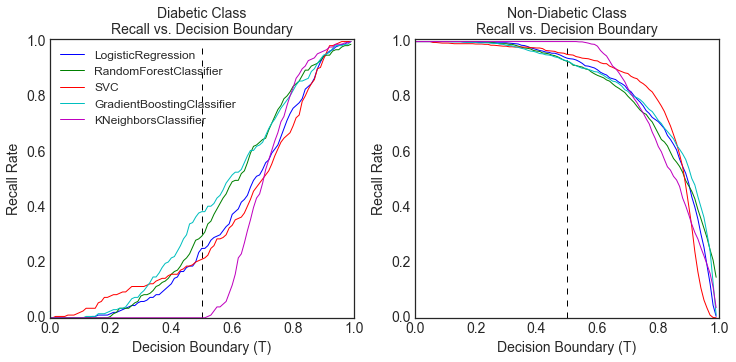

In [22]:
probas = dict(
    GradientBoostingClassifier=gbc_proba,
    KNeighborsClassifier=knn_proba,
    LogisticRegression=lg_proba,
    RandomForestClassifier=rf_proba,
    SVC=svc_proba
)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
ax1.plot([.5, .5], [0, 1], 'k--')
ax2.plot([.5, .5], [0, 1], 'k--')
ax1.set_ylim([0.0, 1.01])
ax1.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.01])
ax2.set_xlim([0.0, 1.0])

ax1.set_xlabel('Decision Boundary (T)', fontsize=14)
ax1.set_ylabel('Recall Rate', fontsize=14)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax2.set_xlabel('Decision Boundary (T)', fontsize=14)
ax2.set_ylabel('Recall Rate', fontsize=14)
ax2.tick_params(axis='both', which='major', labelsize=14)
for p in probas:
    t_precision_nodiab, t_precision_diab, t_recall_nodiab, t_recall_diab = precision_recall_thershold(probas[p])
    ax1.plot(np.arange(0, 1, 0.01), t_recall_diab,   label=p)
    ax1.set_title('Diabetic Class\nRecall vs. Decision Boundary', fontsize=14)
    ax2.plot(np.arange(0, 1, 0.01), t_recall_nodiab, label=p)
    ax2.set_title('Non-Diabetic Class\nRecall vs. Decision Boundary', fontsize=14)

ax1.legend(loc='upper left')
plt.savefig('./img/Recall_score_all.png')
plt.show()

# ROC Curve

In [23]:
def plot_roc_curvs(df_preds, y_test):
    plt.figure(figsize=(8,8))
    for model in df_preds.columns:
        fpr, tpr, thresholds = metrics.roc_curve(
            y_test,
            df_preds.loc[:,model]
        )
        print('{}\n  AUC: {}'.format(model, round(metrics.auc(fpr, tpr), 3)))
        plt.plot(fpr, tpr, label=model)

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.01])
    plt.legend(loc='lower right', fontsize=14)
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('ROC Curve', fontsize=14)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.savefig('./img/ROC_curve.png')
    plt.show()

GradientBoostingClassifier
  AUC: 0.838
KNeighborsClassifier
  AUC: 0.793
LogisticRegression
  AUC: 0.797
RandomForestClassifier
  AUC: 0.816
SVC
  AUC: 0.812
Ensemble
  AUC: 0.834


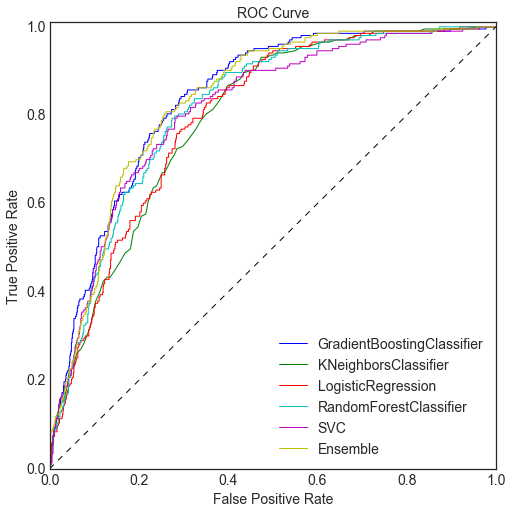

In [24]:
plot_roc_curvs(df_preds, y_test)

### Bootstrap ROC Curve for GradientBoostingClassifier

In [25]:
def bootstrap_model(model, X, y, X_test, y_test, n_bootstrap, thresh):
    total_recall = []
    total_precision = []
    total_fscore = []
    total_fpr_tpr = []
    size = X.shape[0]
    
    for _ in range(n_bootstrap):
        boot_ind = np.random.randint(size, size=size)
        X_boot = X.loc[boot_ind]
        y_boot = y.loc[boot_ind]

        clf = model.fit(X_boot, y_boot)
        y_pred = clf.predict_proba(X_test)[:,0]
        precision, recall, fscore, _ = metrics.precision_recall_fscore_support(
            y_test, 
            np.where(y_pred > thresh, 0, 1)
        )
        
        fpr, tpr, thresholds = metrics.roc_curve(
            y_test,
            1 - y_pred
        )

        fpr_tpr = (fpr, tpr)
        total_fpr_tpr.append(fpr_tpr)
        total_recall.append(recall[1])
        total_precision.append(precision[1])
        total_fscore.append(fscore[1])
        
    results = dict(recall=total_recall,
                   precision=total_precision,
                   fscore=total_fscore,
                   fpr_tpr=total_fpr_tpr)

    return results

In [26]:
# Warning: bootstraping may take a while
results = bootstrap_model(
    gbc_clf,
    X_train, 
    y_train, 
    X_test, 
    y_test,
    10,   # change the number of bootstraps here
    0.5
)

In [27]:
def roc_interp(fpr_tpr):
    linsp = np.linspace(0, 1, 100)
    n_boot = len(fpr_tpr)
    ys = []
    for n in fpr_tpr:
        x, y = n
        interp = np.interp(linsp, x, y)
        ys.append(interp)
    return ys

In [28]:
total_auc = []
for r in results['fpr_tpr']:
    total_auc.append(metrics.auc(r[0], r[1]))

### Bootstrap mean and empirical confidence intervals

In [29]:
np.mean(total_auc)

0.83207909140667768

In [30]:
pd.Series(total_auc).quantile([.025, .975])

0.025    0.827251
0.975    0.837983
dtype: float64

### Bootstrap ROC curve

In [31]:
df_interp = pd.DataFrame(roc_interp(results['fpr_tpr'])).T

In [32]:
m = df_interp.mean(axis=1).values.tolist()
ci = df_interp.quantile([.025, .975], axis=1).values.tolist()

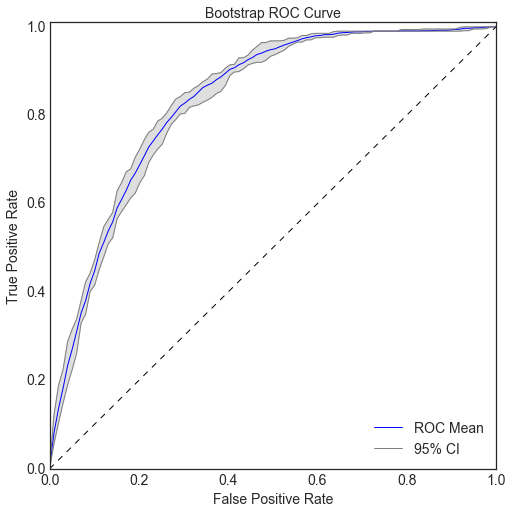

In [33]:
x = np.linspace(0,1,100)

plt.figure(figsize=(8,8))
plt.plot(x, m, c='blue', label='ROC Mean')
plt.plot(x, ci[0], c='grey', label='95% CI')
plt.plot(x, ci[1], c='grey')
plt.fill_between(x, ci[0], ci[1], color='grey', alpha='0.25')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])

plt.legend(loc='lower right', fontsize=14)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Bootstrap ROC Curve', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.savefig('./img/Bootstrap_ROC_confint.png')
plt.show()